# Introducción

Este script hace la ejecución de Extracción, Procesamiento y Carga (ETL) de los archivos del sitio [Quién es Quién en los precios](https://datos.profeco.gob.mx/datos_abiertos/qqp.php).

Una vez procesados estarán disponibles para la parte A y B del trabajo.

In [19]:
# Library installation of resources not in conda environment "arquitectura"
!pip install awswrangler
!pip install boto3
!pip install rarfile
!pip install selenium
!pip install tqdm
!pip install unidecode

In [17]:
# Import libraries
import awswrangler as wr
import csv
import matplotlib.pyplot as plt
import os
import pandas as pd
import rarfile
import re
import requests
import seaborn as sns
import subprocess
import time
from bs4 import BeautifulSoup
from tqdm import tqdm
from unidecode import unidecode


### Carga y Preparacion de datos

Descargar los archivos desde el sitio [Quién es Quién en los precios](https://datos.profeco.gob.mx/datos_abiertos/qqp.php) y descomprimirlos en la carpeta `data/`.

In [17]:
# Function to ensure the data directory exists
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Base URL for making complete links
base_url = "https://datos.profeco.gob.mx/datos_abiertos/"

# URL of the page to scrape
url = "https://datos.profeco.gob.mx/datos_abiertos/qqp.php"

# Ensure the data directory exists
ensure_dir('data')

# Send HTTP GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the HTML content of the page
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find all <li> tags that contain <a> tags within them
    links = soup.find_all('li')
    file_links = []
    
    for link in links:
        a_tag = link.find('a', href=True)
        if a_tag and 'file.php?t=' in a_tag['href']:
            # Create the complete URL for the link
            complete_url = base_url + a_tag['href']
            file_links.append((complete_url, a_tag.text))

    # Visit each link and download the file
    for file_link, name in file_links:
        try:
            # Make the request
            response = requests.get(file_link)
            # Save the content to a file
            if response.status_code == 200:
                file_path = os.path.join('data', name.replace('/', '_') + '.rar')  # Replace slashes just in case
                with open(file_path, 'wb') as file:
                    file.write(response.content)
                print(f"File saved: {file_path}")
            else:
                print(f"Failed to download the file from {file_link}. Status code: {response.status_code}")
        except Exception as e:
            print(f"An error occurred while downloading {file_link}: {str(e)}")
else:
    print("Failed to retrieve the webpage. Status code:", response.status_code)

File saved: data\Base de Datos Histórica Quién es Quién en los Precios 2024.rar
File saved: data\Base de Datos Histórica Quién es Quién en los Precios 2023.rar
File saved: data\Base de Datos Histórica Quién es Quién en los Precios 2022.rar
File saved: data\Base de Datos Histórica Quién es Quién en los Precios 2021.rar
File saved: data\Base de Datos Histórica Quién es Quién en los Precios 2020.rar
File saved: data\Base de Datos Histórica Quién es Quién en los Precios 2019.rar
File saved: data\Base de Datos Histórica Quién es Quién en los Precios 2018.rar
File saved: data\Base de Datos Histórica Quién es Quién en los Precios 2017.rar
File saved: data\Base de Datos Histórica Quién es Quién en los Precios 2016.rar
File saved: data\Base de Datos Histórica Quién es Quién en los Precios 2015.rar


Desempacar los archivos

In [1]:
def unpack_rar_files(directory):
    # Change this path to your 7-Zip executable if it's not in the PATH
    seven_zip_path = "7z"
    
    # List all files in the given directory
    files = os.listdir(directory)
    
    # Filter for .rar files
    rar_files = [file for file in files if file.endswith('.rar')]
    
    # Extract each .rar file
    for rar in rar_files:
        # Construct the full file path
        file_path = os.path.join(directory, rar)
        # Command to extract the files
        command = [seven_zip_path, 'x', file_path, '-o' + directory]
        # Run the command
        subprocess.run(command, check=True)

# Replace 'data' with your directory path if different
unpack_rar_files('data')


Esquema de los archivos

In [2]:
# Define the expected columns based on the provided schema
expected_columns = [
    'producto', 'presentacion', 'marca', 'categoria', 'catalogo', 'precio',
    'fecha_registro', 'cadena_comercial', 'giro', 'nombre_comercial', 'direccion',
    'estado', 'municipio', 'latitud', 'longitud'
]

Directorio que contiene los archivos

In [26]:
# Directory containing the CSV files
data_dir = 'data'  # Adjust this path as needed in your local setup

Encontrar todos los archivos en el directorio "data"

In [69]:
# Function to find all CSV files in directory and subdirectories
def find_csv_files(directory):
    csv_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                csv_files.append(os.path.join(root, file))
    return csv_files

# Get all CSV files
csv_files = find_csv_files(data_dir)

Leer todos los archivos para generar uno solo de la categoría indicada (en este caso, "Material escolar")

In [71]:
# Initialize an empty DataFrame for valid data and one for errors
all_data = pd.DataFrame(columns=['filename'] + expected_columns)
errors = pd.DataFrame(columns=['filename', 'error_row'])

# Function to clean and transform data
def clean_data(data):
    # Remove accents
    for column in data.columns:
        data[column] = data[column].apply(lambda x: unidecode(str(x)) if isinstance(x, str) and pd.notnull(x) else x)
    # Convert to lowercase
    data = data.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
    # Change commas to pipes in 'direccion', considering complex rules
    data['direccion'] = data['direccion'].apply(lambda x: re.sub(r',(?![^"]*"(?:(?:[^"]*"){2})*[^"]*$)', '|', x) if pd.notnull(x) else x)
    return data

# Read each file and validate rows
for file_path in csv_files:
    try:
        # Read the file assuming no headers and using the expected columns
        data = pd.read_csv(file_path, header=None, names=expected_columns)

        # Filter data for 'categoria' equals 'material escolar'
        filtered_data = data[data['categoria'] == 'material escolar']

        # Clean and transform data
        data = clean_data(data)

        # Add filename column to the DataFrame
        data['filename'] = os.path.basename(file_path)

        # Ensure filename is the first column
        data = data[['filename'] + expected_columns]

        # Drop rows and columns that are completely NA
        valid_data = filtered_data.dropna(how='all').dropna(axis=1, how='all')
        
        # Concatenate data while checking for non-empty DataFrame to avoid FutureWarning
        if not valid_data.empty:
            all_data = pd.concat([all_data, valid_data], ignore_index=True)
        
        # Identify invalid rows and add them to the errors DataFrame
        invalid_rows = data[data.isna().any(axis=1)]
        if not invalid_rows.empty:
            invalid_row_str = invalid_rows[expected_columns].apply(lambda x: ','.join(x.fillna('').map(str)), axis=1)
            errors_df = pd.DataFrame({
                'filename': os.path.basename(file_path),
                'error_row': invalid_row_str
            })
            errors = pd.concat([errors, errors_df], ignore_index=True)
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")

# Output results
print(f"Total valid rows loaded: {len(all_data)}")
print(f"Total invalid rows found: {len(errors)}")


Exportar los datos y los errores a la carpeta indicada

In [ ]:
# Export errors df to a csv file
errors.to_csv('./data_clean/errors.csv', index=False)

# Export the cleaned data to a CSV file
all_data.to_csv('./data_clean/all_data.csv', index=False)

# Inicia código de Horus

In [25]:
def procesar_archivo(archivo):
    """Procesa un archivo CSV y quita acentos utilizando unidecode.

    Args:
        archivo (str): La ruta del archivo CSV a procesar.

    Returns:
        pandas.DataFrame: El DataFrame resultante luego de procesar el archivo CSV.
    """

    # Nombres de las columnas
    columnas = [
        "producto", "codigo_producto", "marca", "subcategoria_producto", "categoria_producto",
        "precio", "fecha", "lugar_venta", "tipo_establecimiento", "nombre_establecimiento",
        "direccion_establecimiento", "localidad", "entidad_federativa", "latitud", "longitud"
    ]
    
    # Leer el archivo CSV con los nombres de las columnas especificados, manejo de comas y 
    # lectura de tipo fecha
    df = pd.read_csv(archivo, names=columnas, quoting=csv.QUOTE_MINIMAL, parse_dates=['fecha'])
    
    # Convertir todas las columnas de texto a minúsculas
    df = df.apply(lambda col: col.str.lower() if col.dtype == 'object' else col)
    
    # Quitar acentos de las columnas de tipo string
    for columna in df.select_dtypes(include=['object']).columns:
        df[columna] = df[columna].apply(lambda x: unidecode(x) if isinstance(x, str) else x)
        
    return df

# Directorio donde se encuentran los archivos
directorio_base = 'D:/Horus/Documentos/MGEProyecto_20240417'

# Caracteres iniciales de las carpetas a considerar
caracteres_iniciales = ['20']

# Lista para almacenar los DataFrames de cada archivo
dataframes = []

# Recorrer los directorios correspondientes a los años
for carpeta in tqdm(os.listdir(directorio_base), desc="Procesando directorios"):
    if any(carpeta.startswith(c) for c in caracteres_iniciales) and \
       os.path.isdir(os.path.join(directorio_base, carpeta)):
        # Recorrer los archivos CSV dentro de la carpeta
        for archivo_csv in tqdm(os.listdir(os.path.join(directorio_base, carpeta)), desc="Procesando archivos"):
            if archivo_csv.endswith('.csv'):
                ruta_archivo = os.path.join(directorio_base, carpeta, archivo_csv)
                # Procesar el archivo CSV y aplicar el filtro directamente
                df = procesar_archivo(ruta_archivo)
                df_filtrado = df[df['subcategoria_producto'] == 'material escolar']
                # Agregar el DataFrame filtrado a la lista
                dataframes.append(df_filtrado)

# Concatenar todos los DataFrames en uno solo
dataframe_final = pd.concat(dataframes, ignore_index=True)

# Mostrar las primeras 20 filas del DataFrame final
print(dataframe_final.head(20))

# Información adicional
print(f"Total de registros procesados: {len(dataframe_final)}")
print(f"Total de variables: {len(dataframe_final.columns)}")
print("Total de variables por tipo de variable:")
print(dataframe_final.dtypes.value_counts())

Procesando directorios:   0%|          | 0/16 [00:00<?, ?it/s]

Procesando directorios: 100%|██████████| 16/16 [09:09<00:00, 34.31s/it]


                 producto                                    codigo_producto  \
0   boligrafo tinta negra         blister 3 piezas. retractil. punto mediano   
1   boligrafo tinta negra                      bolsa 4 piezas. punto mediano   
2   boligrafo tinta negra                         bolsa 4 piezas. punto fino   
3   boligrafo tinta negra                      bolsa 3 piezas. punto mediano   
4   boligrafo tinta negra                     blister 3 piezas. punto grueso   
5   boligrafo tinta negra                    blister 2 piezas. punto mediano   
6   boligrafo tinta negra                  bolsa 2 piezas. punto mediano (m)   
7          cinta adhesiva  blister 1 pieza. 19 mm. x 30 m 550. transparen...   
8          cinta adhesiva  blister 1 pieza. 12 mm. x 30 m. transparente. ...   
9       colores de madera                              caja 12 piezas. largo   
10      colores de madera                              caja 18 piezas. largo   
11      colores de madera               

### Se exportan los csv a local con el proesamiento y estructrua de carpetas para partcion por Año

In [9]:
# Crear la carpeta raíz 'dataanthena' si no existe
root_folder = 'dataanthena'
os.makedirs(root_folder, exist_ok=True)

# Crear un directorio para cada año y exportar los datos filtrados en un archivo CSV en ese directorio solo si no existe previamente
for year in dataframe_final['fecha'].dt.year.unique():
    year_folder = os.path.join(root_folder, f'{year}')
    os.makedirs(year_folder, exist_ok=True)
    csv_path = os.path.join(year_folder, 'profeco.csv')
    if not os.path.exists(csv_path):
        dataframe_final[dataframe_final['fecha'].dt.year == year].to_csv(csv_path, sep='|', index=False)
        print(f"Se han exportado los datos de {year} a {csv_path}")
    else:
        print(f"Los datos para {year} ya existen en {csv_path}.")

# s3://itam-athena-queries-horus/mgeproject/

Se han exportado los datos de 2018 a dataanthena\2018\profeco.csv
Los datos para 2019 ya existen en dataanthena\2019\profeco.csv.
Los datos para 2021 ya existen en dataanthena\2021\profeco.csv.
Los datos para 2022 ya existen en dataanthena\2022\profeco.csv.
Los datos para 2024 ya existen en dataanthena\2024\profeco.csv.


### Sesión en S3 para poder hacer consultas y responder preguntas con la tabla profeco Material Escolar

In [12]:
# Abres un cliente de S3
import boto3
session = boto3.Session(profile_name='arquitectura', region_name="us-east-1")
s3 = session.client('s3')

# Crea un nuevo Bucket
# OJO: Aqui cambia el nombre del bucket, utiliza tu nombre como sufijo, para
# que sea único en el mundo, si no te va a salir error. Si tuviste éxito, el
# API de boto3 te va a regresar un HTTPStatusCode de 200. Eso es éxito.
BUCKET_NAME = "itam-athena-queries-horus"


### 1) ¿De qué año a qué año tienen datos de esa categoría (Material Escolar)?

In [27]:
query_profeco = '''
SELECT
  MIN(year) AS minimo_anio,
  MAX(year) AS maximo_anio
FROM
  profeco_db.profeco;
'''

result = wr.athena.read_sql_query(query_profeco,
                                   database="profeco_db",
                                   ctas_approach=False,
                                   boto3_session=session)
print(result)

   minimo_anio  maximo_anio
0         2018         2024


### 2) ¿Cuántos registros de fecha hay vacíos (Material Escolar)?

In [21]:
query_fecha_vacia = '''
SELECT
  COUNT(*) AS registros_fecha_vacia
FROM
  profeco_db.profeco
WHERE
  fecha IS NULL OR CAST(fecha AS VARCHAR) = '';
'''

result_fecha_vacia = wr.athena.read_sql_query(query_fecha_vacia,
                                              database="profeco_db",
                                              ctas_approach=False,
                                              boto3_session=session)

print(result_fecha_vacia)


   registros_fecha_vacia
0                      0


### 3) ¿Cuántos registros tienes por año?

In [47]:
query_registros_por_anio = '''
SELECT
  year,
  COUNT(*) AS total_registros
FROM
  profeco_db.profeco
GROUP BY
  year
ORDER BY
  year ASC;
'''

resultado_registros_por_anio = wr.athena.read_sql_query(query_registros_por_anio,
                                                        database="profeco_db",
                                                        ctas_approach=False,
                                                        boto3_session=session)
print(resultado_registros_por_anio)


   year  total_registros
0  2018            56876
1  2019           102049
2  2021           122839
3  2022            41794
4  2024            62064


### 4) ¿Cuál es el precio mínimo, máximo, promedio, desviación estándar, mediana, cuantil 25 y 75% de tu categoría por año?

In [46]:
query_metricas_precio = '''
SELECT
  year(fecha) AS anio,
  MIN(precio) AS precio_minimo,
  MAX(precio) AS precio_maximo,
  AVG(precio) AS precio_promedio,
  STDDEV(precio) AS desviacion_estandar,
  APPROX_PERCENTILE(precio, 0.5) AS mediana,
  APPROX_PERCENTILE(precio, 0.25) AS cuantil_25,
  APPROX_PERCENTILE(precio, 0.75) AS cuantil_75
FROM
  profeco_db.profeco
GROUP BY
  year(fecha)
ORDER BY
  anio ASC;
'''

resultado_metricas_precio = wr.athena.read_sql_query(query_metricas_precio,
                                                     database="profeco_db",
                                                     ctas_approach=False,
                                                     boto3_session=session)
print(resultado_metricas_precio)


   anio  precio_minimo  precio_maximo  precio_promedio  desviacion_estandar  \
0  2018           0.68     543.000000        50.255665            48.420253   
1  2019           1.00     595.000000        54.219292            51.723571   
2  2021           1.00     756.179993        63.173550            62.683659   
3  2022           1.00     774.309998        67.182060            64.511646   
4  2024           1.43     758.000000        76.139099            73.547451   

     mediana  cuantil_25  cuantil_75  
0  38.086189   20.968925   62.681988  
1  40.177975   21.716717   69.014137  
2  44.669937   24.739460   80.283936  
3  47.161289   25.329071   86.832985  
4  53.588860   29.102730   96.582611  


### 5) ¿Cuáles son el top 5 de marcas con mayor precio en cada estado  (Material Escolar)? 

In [58]:
query_top5_marcas_precio_promedio_por_estado = '''
WITH avg_price_per_brand AS (
  SELECT
    localidad,
    marca,
    AVG(precio) AS precio_promedio
  FROM
    profeco_db.profeco
  GROUP BY
    localidad,
    marca
),
ranked_brands AS (
  SELECT
    localidad,
    marca,
    precio_promedio,
    ROW_NUMBER() OVER (PARTITION BY localidad ORDER BY precio_promedio DESC) AS ranking
  FROM
    avg_price_per_brand
)
SELECT
  localidad,
  marca,
  precio_promedio
FROM
  ranked_brands
WHERE
  ranking <= 5;
'''

resultado_top5_marcas_precio_promedio_por_estado = wr.athena.read_sql_query(query_top5_marcas_precio_promedio_por_estado,
                                                                           database="profeco_db",
                                                                           ctas_approach=False,
                                                                           boto3_session=session)
print(resultado_top5_marcas_precio_promedio_por_estado)


               localidad                        marca  precio_promedio
0    baja california sur                        casio       313.072601
1    baja california sur  norma. mis primeros colores       242.947495
2    baja california sur                       celica       230.519287
3    baja california sur                           hp       219.000000
4    baja california sur            pilot. the shaker       212.000000
..                   ...                          ...              ...
155             tlaxcala                        casio       290.704376
156             tlaxcala                           hp       239.000000
157             tlaxcala                       celica       231.000000
158             tlaxcala                sony (1x-48x)       220.399994
159             tlaxcala            pilot. the shaker       212.333328

[160 rows x 3 columns]


### 6) ¿Cuáles son el top 5 de marcas con menor precio en CDMX? 

In [50]:
query_top5_marcas_menor_precio_cdmx = '''
SELECT
  marca,
  AVG(precio) AS precio_promedio
FROM
  profeco_db.profeco
WHERE
  localidad = 'ciudad de mexico'
GROUP BY
  marca
ORDER BY
  precio_promedio ASC
LIMIT 5;
'''

resultado_top5_marcas_menor_precio_cdmx = wr.athena.read_sql_query(query_top5_marcas_menor_precio_cdmx,
                                                                   database="profeco_db",
                                                                   ctas_approach=False,
                                                                   boto3_session=session)
print(resultado_top5_marcas_menor_precio_cdmx)


              marca  precio_promedio
0        sony (48x)         5.994595
1  office max. om30         7.500000
2           popular         9.172501
3    papermate. gel        10.079787
4             janel        11.279653


### 7) ¿Cuáles son el top 5 de marcas con mayores observaciones? ¿Se parecen a las de nivel por estado? 

In [61]:
# Consulta para obtener el top 5 de marcas con mayores observaciones a nivel nacional
query_top5_marcas_mas_observaciones_nacional = '''
SELECT
  marca,
  COUNT(*) AS total_observaciones
FROM
  profeco_db.profeco
GROUP BY
  marca
ORDER BY
  total_observaciones DESC
LIMIT 5;
'''

# Consulta para obtener el top 5 de marcas con mayores observaciones por estado
query_top5_marcas_mas_observaciones_estado = '''
WITH observaciones_por_estado AS (
  SELECT
    localidad,
    marca,
    COUNT(*) AS total_observaciones
  FROM
    profeco_db.profeco
  GROUP BY
    localidad,
    marca
)
SELECT
  localidad,
  marca,
  total_observaciones
FROM (
  SELECT
    localidad,
    marca,
    total_observaciones,
    ROW_NUMBER() OVER (PARTITION BY localidad ORDER BY total_observaciones DESC) AS ranking_estado
  FROM
    observaciones_por_estado
) ranked_brands
WHERE
  ranking_estado <= 5;
'''

# Ejecutar la consulta a nivel nacional
resultado_top5_marcas_mas_observaciones_nacional = wr.athena.read_sql_query(query_top5_marcas_mas_observaciones_nacional,
                                                                           database="profeco_db",
                                                                           ctas_approach=False,
                                                                           boto3_session=session)

# Ejecutar la consulta por estado
resultado_top5_marcas_mas_observaciones_estado = wr.athena.read_sql_query(query_top5_marcas_mas_observaciones_estado,
                                                                         database="profeco_db",
                                                                         ctas_approach=False,
                                                                         boto3_session=session)

print("Top 5 de marcas con mayores observaciones a nivel nacional:")
print(resultado_top5_marcas_mas_observaciones_nacional)
print("\nTop 5 de marcas con mayores observaciones por estado:")
print(resultado_top5_marcas_mas_observaciones_estado)


Top 5 de marcas con mayores observaciones a nivel nacional:
                    marca  total_observaciones
0                 crayola                41804
1                     s/m                23123
2          bic. evolution                18899
3  pritt. original (rojo)                10635
4            norma. color                 9845

Top 5 de marcas con mayores observaciones por estado:
    localidad                   marca  total_observaciones
0    campeche                 crayola                 1054
1    campeche                     s/m                  764
2    campeche          bic. evolution                  512
3    campeche  pritt. original (rojo)                  295
4    campeche      paper mate. mirado                  273
..        ...                     ...                  ...
155   sinaloa                 crayola                  450
156   sinaloa                     s/m                  217
157   sinaloa          bic. evolution                  197
158   sinaloa

### 8) Genera un boxplot por año, para cada una de las top 5 marcas de tu categoría.

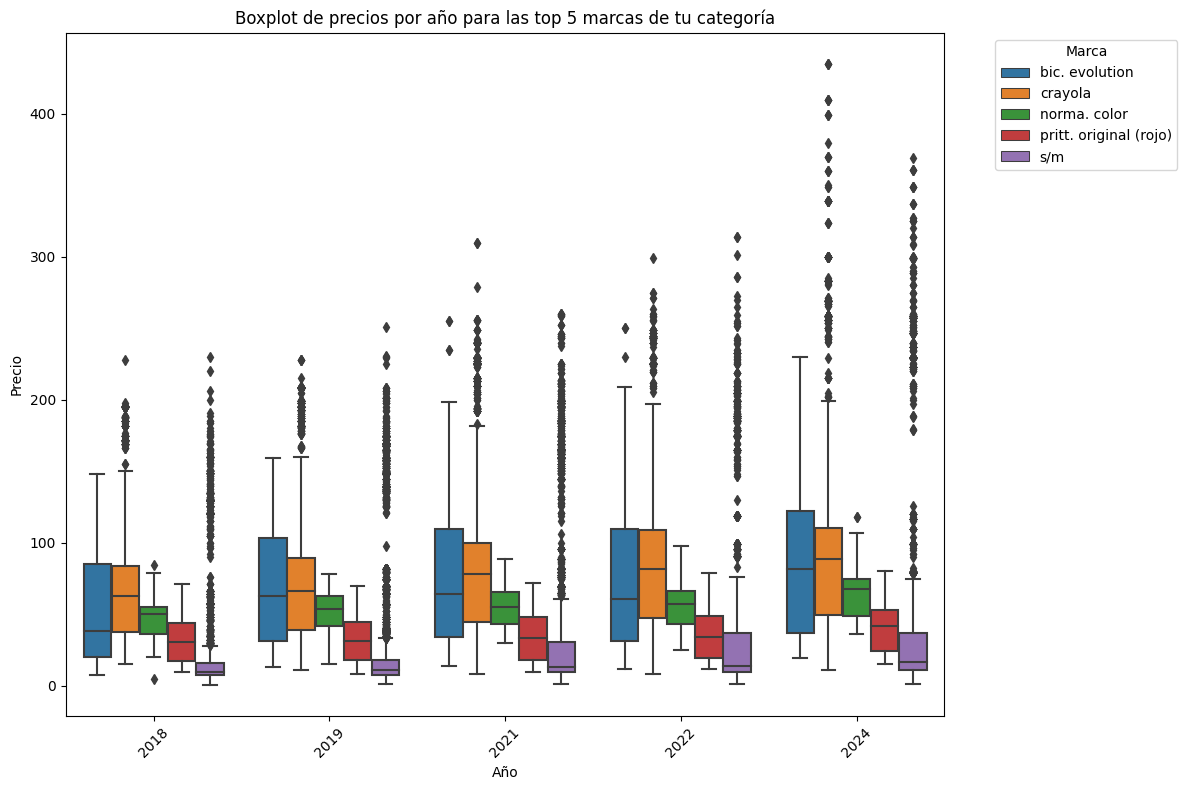

In [71]:
# Lista de las top 5 marcas de tu categoría
top_marcas = resultado_top5_marcas_mas_observaciones_nacional['marca'].tolist()

# Consulta para obtener los datos de precios por año para cada una de las top marcas
query_precios_por_marca_por_anio = '''
SELECT
  year,
  marca,
  precio
FROM
  profeco_db.profeco
WHERE
  marca IN {}
'''.format(tuple(top_marcas))

# Ejecutar la consulta
datos_precios_por_marca_por_anio = wr.athena.read_sql_query(query_precios_por_marca_por_anio,
                                                             database="profeco_db",
                                                             ctas_approach=False,
                                                             boto3_session=session)

# Crear un boxplot por año para cada una de las top marcas de tu categoría
plt.figure(figsize=(12, 8))
sns.boxplot(data=datos_precios_por_marca_por_anio, x='year', y='precio', hue='marca')
plt.title('Boxplot de precios por año para las top 5 marcas de tu categoría')
plt.xlabel('Año')
plt.ylabel('Precio')
plt.xticks(rotation=45)
plt.legend(title='Marca', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
